# **Urbana's Crime Landscape: A Data-Driven Approach to Predicting Arrests**

## Team Members:
* Anusha Verma Chandraju (avc5)
* Deekshita Karingula (dk55)
* Neeharika Vijayakumar (nv25)

This project aims to understand the crime data of urbana. We had used the open data website for the city of Urbana: https://data.urbanaillinois.us/

We primarily use two datasets for this project:
* The Incidents dataset which has data relating to the crime incidents that took place from 1988 - Feb 2023
* The Arrests dataset on the other hand focused from 1988 - Feb 2023.

Methodology of the project:
* Data-Preprocessing and Merging in R and Python
* Statistical Analysis of the merged dataset
* Machine learning model for predicting the arrests resolution






In [2]:
#Importing the libraries

import os
from google.colab import drive
import pandas as pd

drive.mount('/content/drive')# This will prompt you to authorize the Google Drive connection
os.chdir('/content/drive/My Drive/datastatsproject') # Change directory to the folder containing the CSV file

Mounted at /content/drive


In [3]:
# Loading the dataset
data=pd.read_csv('data.csv')

<ipython-input-3-76a2f0e7a33f>:2: DtypeWarning: Columns (26,27,28) have mixed types. Specify dtype option on import or set low_memory=False.
  data=pd.read_csv('data.csv')


In [4]:

# Age Preprocessing
data.loc[data['AGE.AT.ARREST'].isin([-7172,-7171,-1,-2,0,1,3,5,6,7,8,9]), 'AGE.AT.ARREST'] = 'Unknown'

In [5]:

#street preprocessing
top_10_categories = data['STREET'].value_counts().head(10)
print(top_10_categories)
def grouping(arr,data,x):
  for i in arr:
    pattern = r'{}'.format(i)
    data.loc[data[x].str.contains(pattern), x] = i


#Grouping
streets_group=['LINCOLN','UNIVERSITY','CUNNINGHAM','WASHINGTON','PHILO','MAIN','VINE','BROADWAY','BRADLEY','FLORIDA']
grouping(streets_group,data,'STREET')

#street preprocessing
top_10_categories = data['STREET'].value_counts().head(10)
print(top_10_categories)

LINCOLN             14576
CUNNINGHAM AVE N    13935
LINCOLN AVE N       13515
CUNNINGHAM          11646
UNIVERSITY           9894
UNIVERSITY AVE W     8737
LINCOLN AVE          7853
PHILO RD             7547
WASHINGTON ST E      6799
WASHINGTON           6566
Name: STREET, dtype: int64
LINCOLN       51852
CUNNINGHAM    38702
UNIVERSITY    38390
WASHINGTON    21651
VINE          20801
MAIN          20405
PHILO         16792
BROADWAY      16388
FLORIDA       14414
BRADLEY       11693
Name: STREET, dtype: int64


In [6]:

#street changing the rest of the column values to 'Other'
top10=data['STREET'].value_counts().index[:10].tolist()
data.loc[~data['STREET'].isin(top10), 'STREET'] = 'Other'
#street preprocessing
data['STREET'].value_counts()

#dropping violation and statute
data= data.drop(columns=['VIOLATION','STATUTE'])

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Replacing all '24:00' time values with '00:00' and changing the format of the columns to 'HH:MM'
columns_to_fix = ['TIME.OCCURRED', 'TIME.REPORTED', 'TIME.ARRIVED']

for column in columns_to_fix:
    data[column] = data[column].replace('24:00', '00:00')
    data[column] = pd.to_datetime(data[column], format='%H:%M').dt.strftime('%H:%M')

# Replacing all the blank cells with NaT values
date_columns = ['DATE.OCCURRED', 'DATE.REPORTED', 'DATE.ARRIVED']
time_columns = ['TIME.OCCURRED', 'TIME.REPORTED']

for col in date_columns:
    data[col] = pd.to_datetime(data[col], errors='coerce')

data['TIME.OCCURRED'] = pd.to_datetime(data['TIME.OCCURRED'], errors='coerce').dt.strftime('%H:%M')

# Checking whether the time and date values of the record are missing and removing such records, as they signify missing values
for col in time_columns:
    mask = (data[col] == '00:00') & (data[date_columns[time_columns.index(col)]].isnull() | (data[date_columns[time_columns.index(col)]] == 0))
    rows_changed = len(data.loc[mask])
    data.loc[mask, col] = pd.NaT

    data[col] = pd.to_datetime(data[col])
    data[f'HOUR.{col.split(".")[1]}'] = data[col].dt.hour
    incident_count_by_hour = data[f'HOUR.{col.split(".")[1]}'].value_counts().sort_index()



In [8]:
# Rename 'TIME.ARRIVED' to 'HOUR.ARRIVED'
data.rename(columns={'TIME.ARRIVED': 'HOUR.ARRIVED'}, inplace=True)

# **Statistical Analysis**

In this section, we focus on understanding the trends and relationships that are observed in the urbana crime dataset

Top 10 Crime Categories

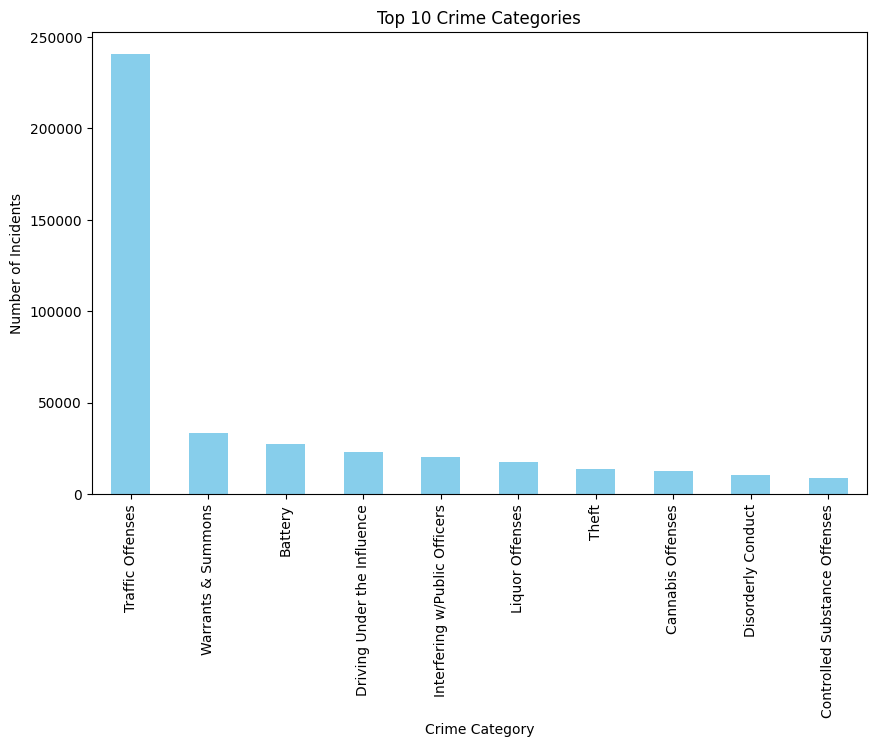

In [9]:
crime_counts = data['CRIME.CATEGORY.DESCRIPTION'].value_counts()

top_10_crimes = crime_counts.head(10)

plt.figure(figsize=(10, 6))
top_10_crimes.plot(kind='bar', color='skyblue')
plt.title('Top 10 Crime Categories')
plt.xlabel('Crime Category')
plt.ylabel('Number of Incidents')
plt.show()

Analysing Incident Statuses Over the Last 10 Years

<Figure size 1200x600 with 0 Axes>

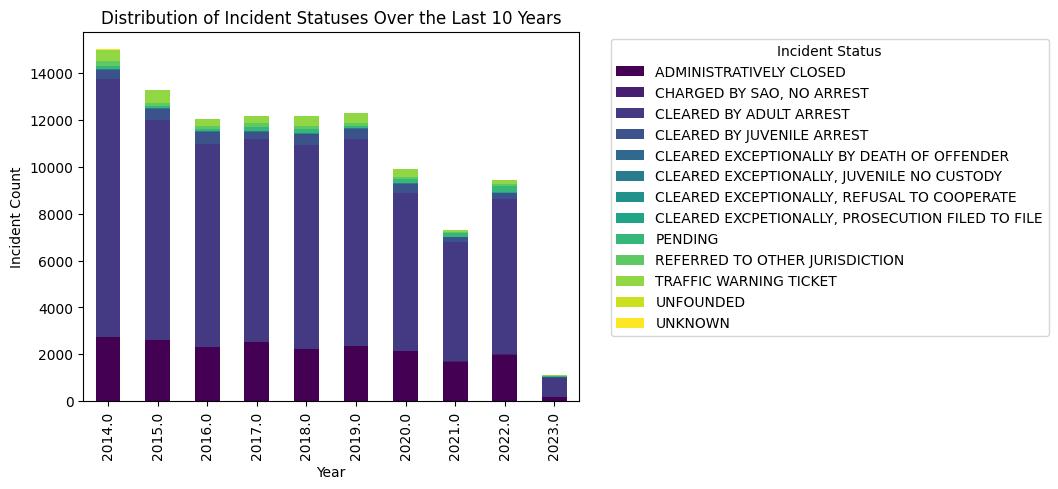

In [10]:
data['DATE.OCCURRED'] = pd.to_datetime(data['DATE.OCCURRED'])
data['Year'] = data['DATE.OCCURRED'].dt.year

recent_data = data[data['Year'] >= (data['Year'].max() - 9)]

incident_status_count = recent_data.groupby(['Year', 'STATUS.DESCRIPTION']).size().unstack(fill_value=0)

plt.figure(figsize=(12, 6))
incident_status_count.plot(kind='bar', stacked=True, colormap='viridis')
plt.title('Distribution of Incident Statuses Over the Last 10 Years')
plt.xlabel('Year')
plt.ylabel('Incident Count')
plt.legend(title='Incident Status', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

Number of Incidents by year

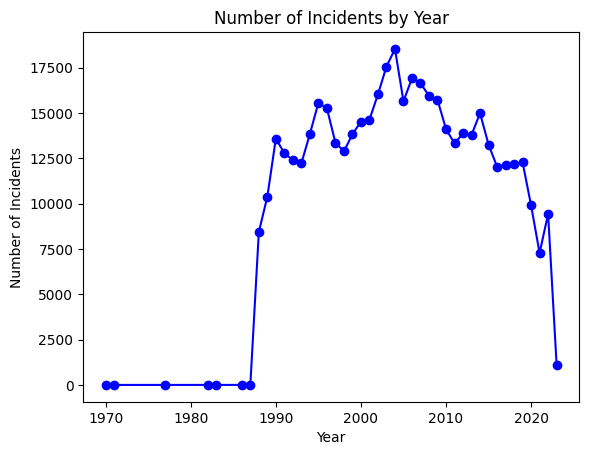

In [11]:
data['YEAR.OCCURRED'] = data['YEAR.OCCURRED']
total_incidents_by_year = data['YEAR.OCCURRED'].value_counts().sort_index()

plt.plot(total_incidents_by_year.index, total_incidents_by_year.values, marker='o', linestyle='-', color='b')
plt.title('Number of Incidents by Year')
plt.xlabel('Year')
plt.ylabel('Number of Incidents')
plt.show()


Monthly Incident Distribution

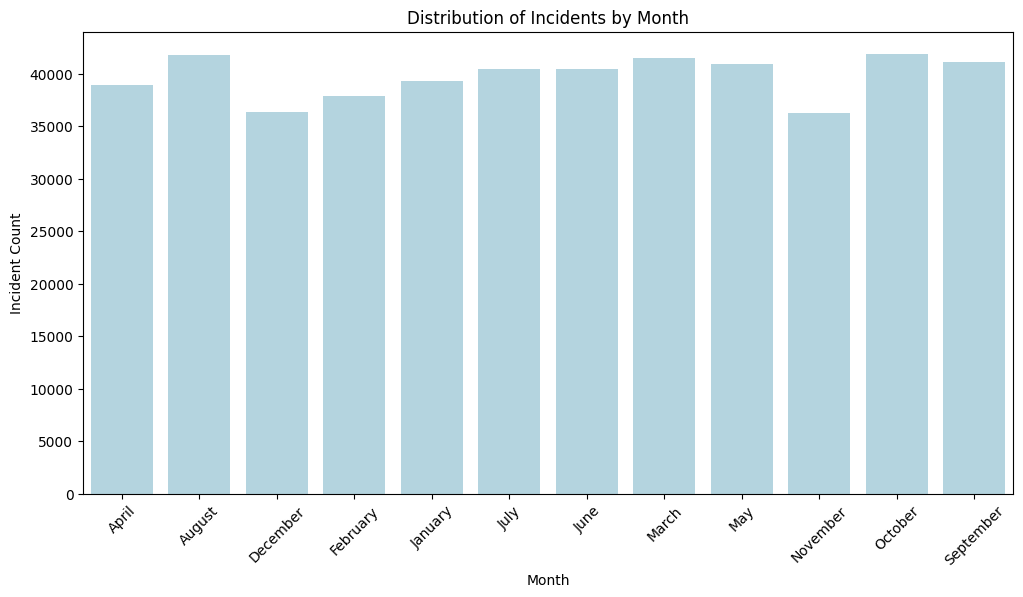

In [12]:
data['DATE.OCCURRED'] = pd.to_datetime(data['DATE.OCCURRED'])
data['Month'] = data['DATE.OCCURRED'].dt.month_name()

incident_count_by_month = data['Month'].value_counts().sort_index()

plt.figure(figsize=(12, 6))
sns.barplot(x=incident_count_by_month.index, y=incident_count_by_month.values, color='lightblue')
plt.title('Distribution of Incidents by Month')
plt.xlabel('Month')
plt.ylabel('Incident Count')
plt.xticks(rotation=45)
plt.show()

Analysing the variation in frequency of incidents over 10 years

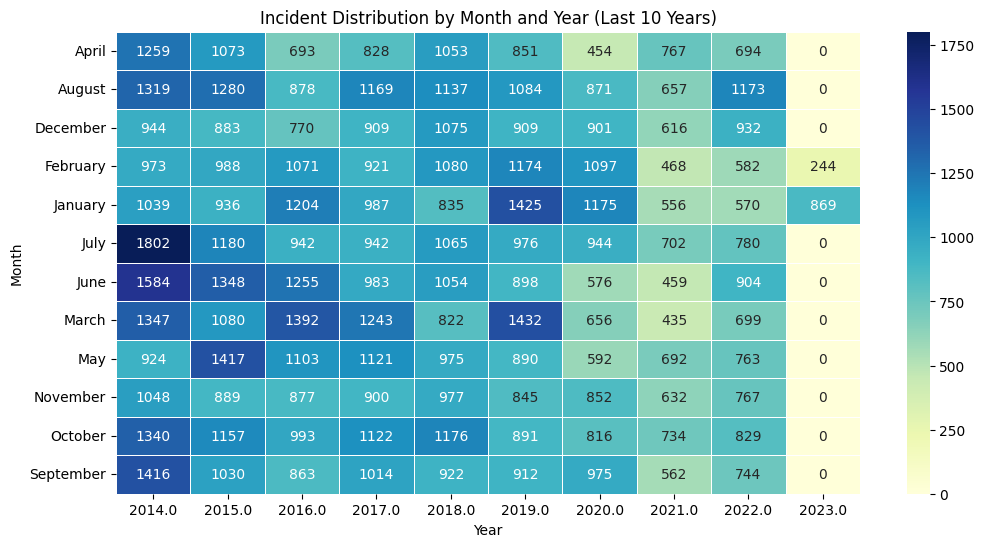

In [13]:
data['DATE.OCCURRED'] = pd.to_datetime(data['DATE.OCCURRED'])
data['Year'] = data['DATE.OCCURRED'].dt.year
data['Month'] = data['DATE.OCCURRED'].dt.month_name()

recent_data = data[data['Year'] >= (data['Year'].max() - 9)]

heatmap_data_recent = recent_data.groupby(['Month', 'Year']).size().unstack().fillna(0)

plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data_recent, cmap='YlGnBu', annot=True, fmt='g', linewidths=.5)
plt.title('Incident Distribution by Month and Year (Last 10 Years)')
plt.xlabel('Year')
plt.ylabel('Month')
plt.show()


Hourly Analysis of Incident Occurrence Times

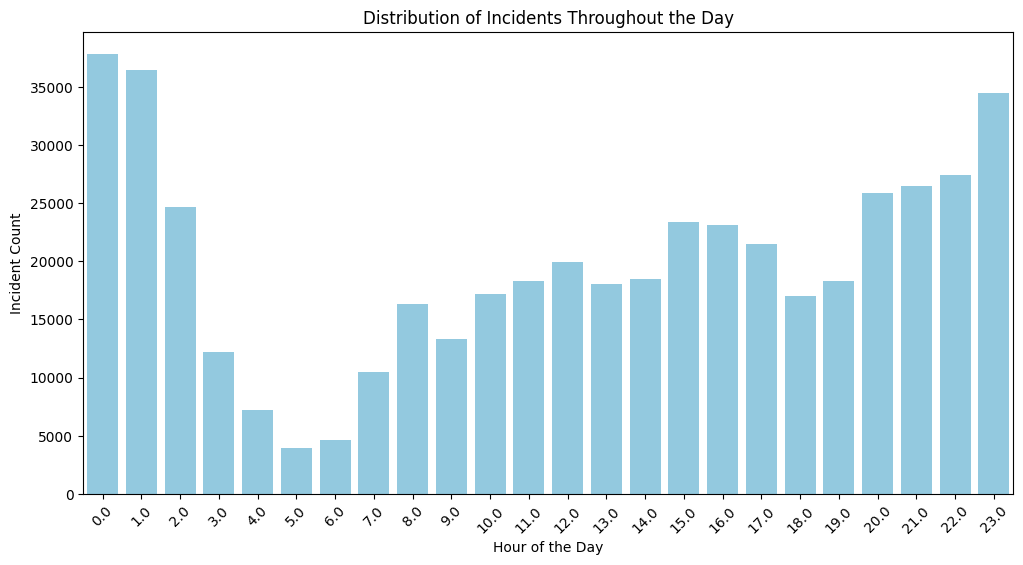

In [14]:
mask = (data['TIME.OCCURRED'] == '00:00') & (data['DATE.OCCURRED'].isnull() | (data['DATE.OCCURRED'] == 0))

rows_changed = len(data.loc[mask])

data.loc[mask, 'TIME.OCCURRED'] = pd.NaT  # Use pd.NaT to represent null values for datetime columns

data['Hour'] = data['TIME.OCCURRED'].dt.hour
incident_count_by_hour = data['Hour'].value_counts().sort_index()

plt.figure(figsize=(12, 6))
sns.barplot(x=incident_count_by_hour.index, y=incident_count_by_hour.values, color='skyblue')
plt.title('Distribution of Incidents Throughout the Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Incident Count')
plt.xticks(rotation=45)
plt.show()

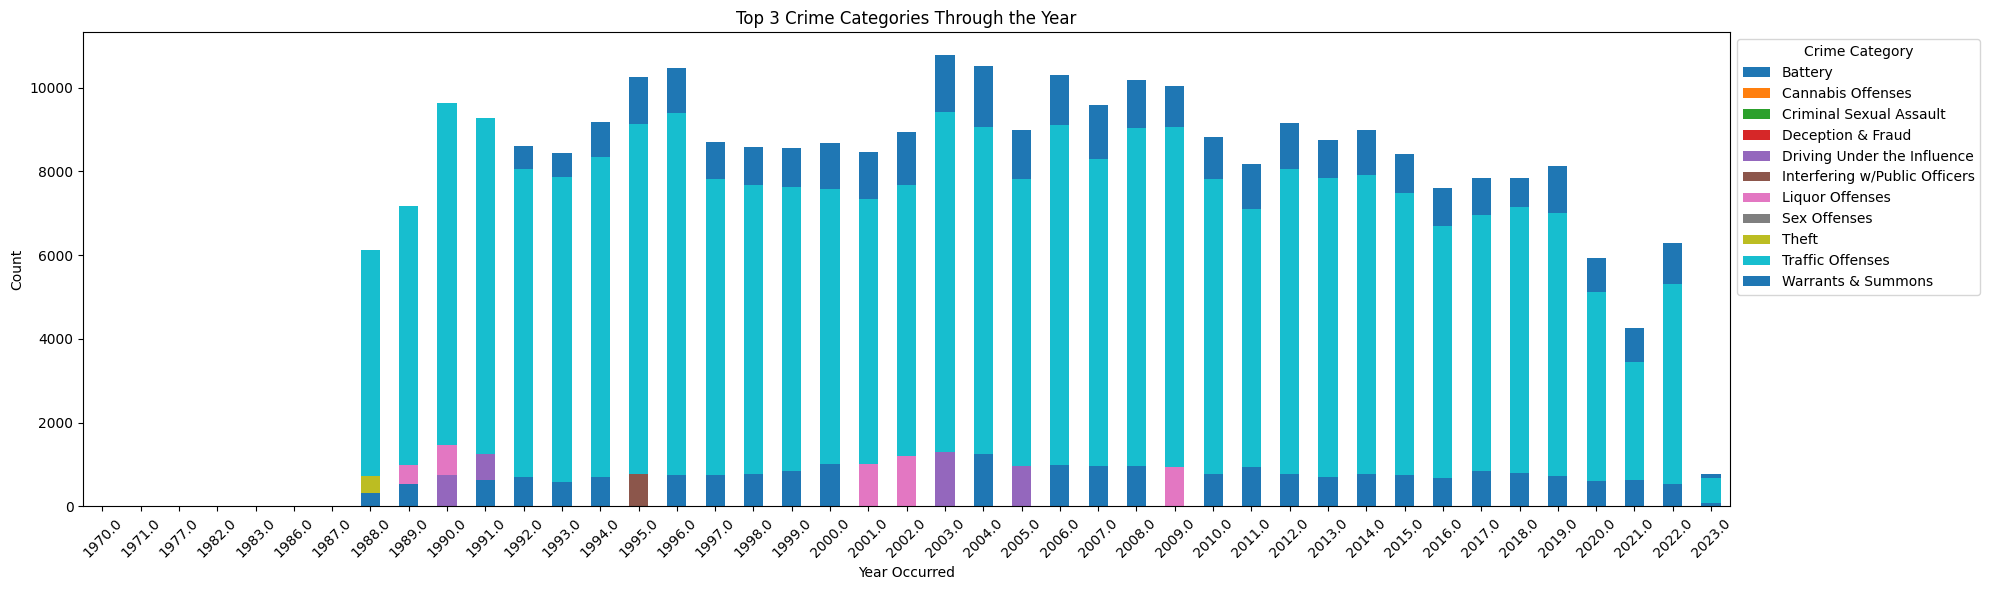

In [15]:
# Visualization depicting the top 3 crime categories through the years

top_crime_categories = data.groupby(['YEAR.OCCURRED', 'CRIME.CATEGORY.DESCRIPTION'])['CRIME.CATEGORY.DESCRIPTION'].count().reset_index(name='COUNT')
top_crime_categories = top_crime_categories.sort_values(by=['YEAR.OCCURRED', 'COUNT'], ascending=[True, False])#Sorting the column
top_crime_categories = top_crime_categories.groupby('YEAR.OCCURRED').head(3)#Finding the top 3
pivot_df = top_crime_categories.pivot(index='YEAR.OCCURRED', columns='CRIME.CATEGORY.DESCRIPTION', values='COUNT').fillna(0)

# Plotting a stacked bar chart
pivot_df.plot(kind='bar', stacked=True, figsize=(20,6))
plt.title('Top 3 Crime Categories Through the Year')
plt.xlabel('Year Occurred')
plt.ylabel('Count')
plt.legend(title='Crime Category', bbox_to_anchor=(1, 1))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### **Analysis of Juvenile (10-17 year old) Arrestees**

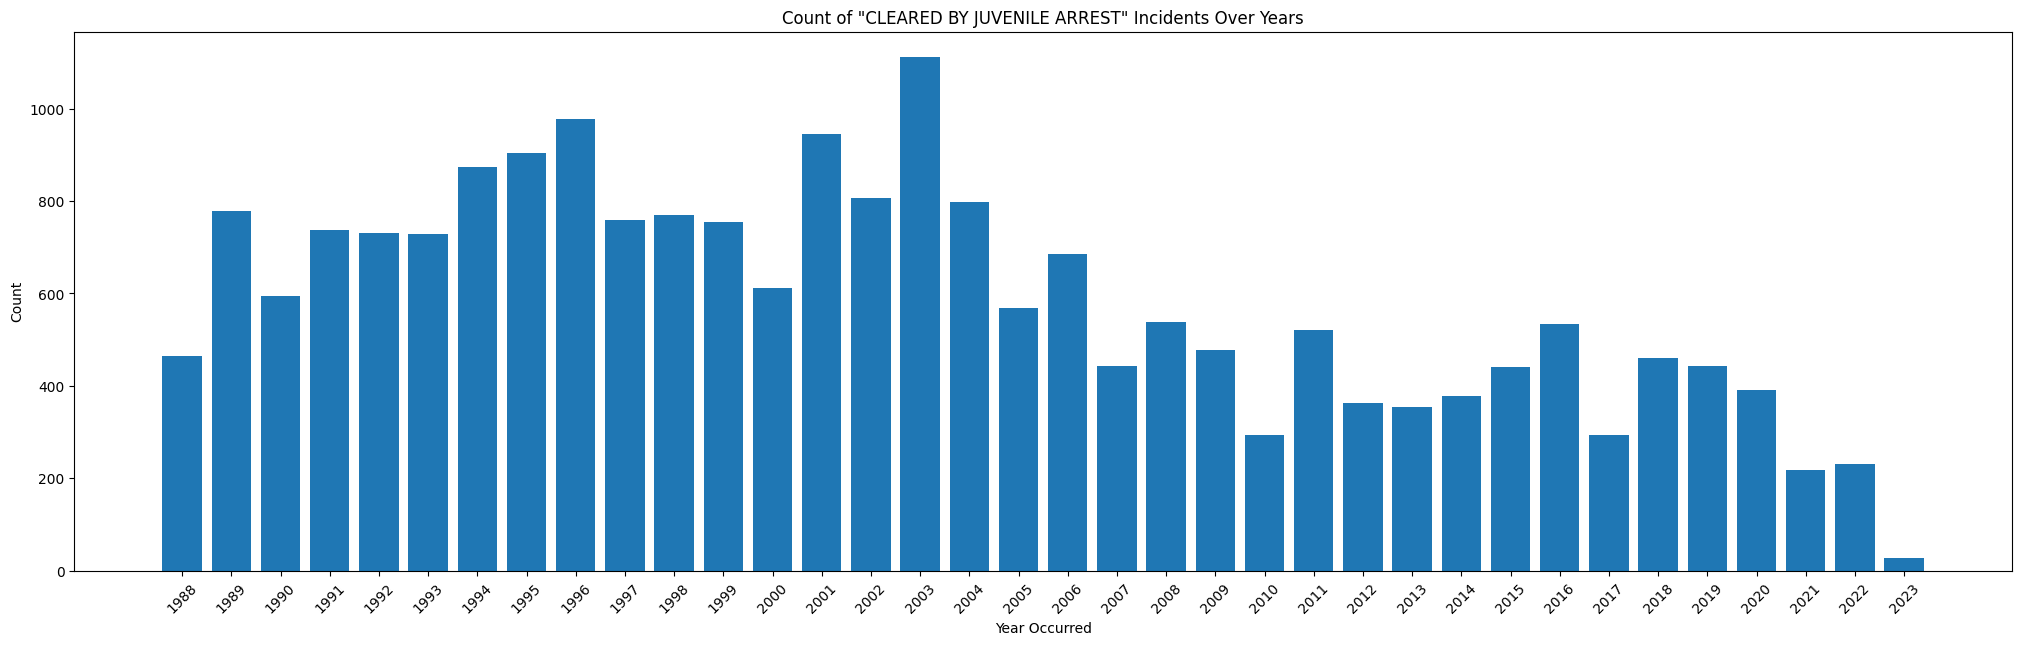

In [16]:
#Visualization depicting the number of cleared by juvenile arrests cases through the years

plt.figure(figsize=(25,7))#Creating the plot
filtered_data = data[data['STATUS.DESCRIPTION'] == 'CLEARED BY JUVENILE ARREST']# Filter data for 'CLEARED BY JUVENILE ARREST' incidents
counts_by_year = filtered_data['YEAR.OCCURRED'].value_counts().sort_index()# Group by 'YEAR.OCCURRED' and get count
plt.xticks(rotation=45)
plt.bar(counts_by_year.index.astype(int).astype(str), counts_by_year)
plt.title('Count of "CLEARED BY JUVENILE ARREST" Incidents Over Years')
plt.xlabel('Year Occurred')
plt.ylabel('Count')
plt.show()


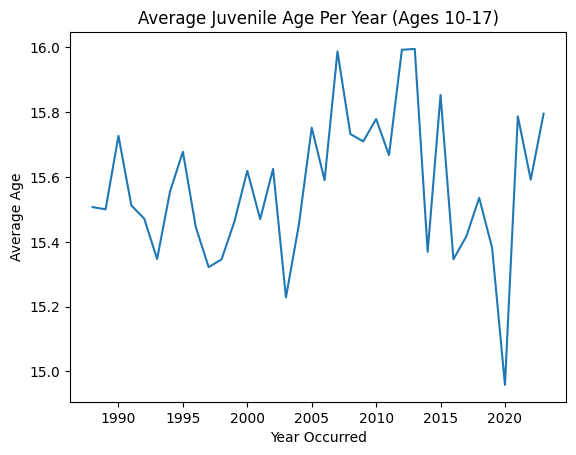

In [17]:
#Visualization depicting the average age for juveniles through the years
import numpy as np
data['AGE.AT.ARREST'] = data['AGE.AT.ARREST'].replace('Unknown', np.nan)
juveniles_df = data[(data['AGE.AT.ARREST'] >= 10) & (data['AGE.AT.ARREST'] <= 17)]# filter data for juveniles (ages 10 to 17)
juvenile_age_mean = juveniles_df.groupby('YEAR.OCCURRED')['AGE.AT.ARREST'].mean().reset_index() # groupby year and calculate average age of juveniles
plt.plot(juvenile_age_mean['YEAR.OCCURRED'], juvenile_age_mean['AGE.AT.ARREST']) # creating the plot
plt.title('Average Juvenile Age Per Year (Ages 10-17)')
plt.xlabel('Year Occurred')
plt.ylabel('Average Age')
plt.show()


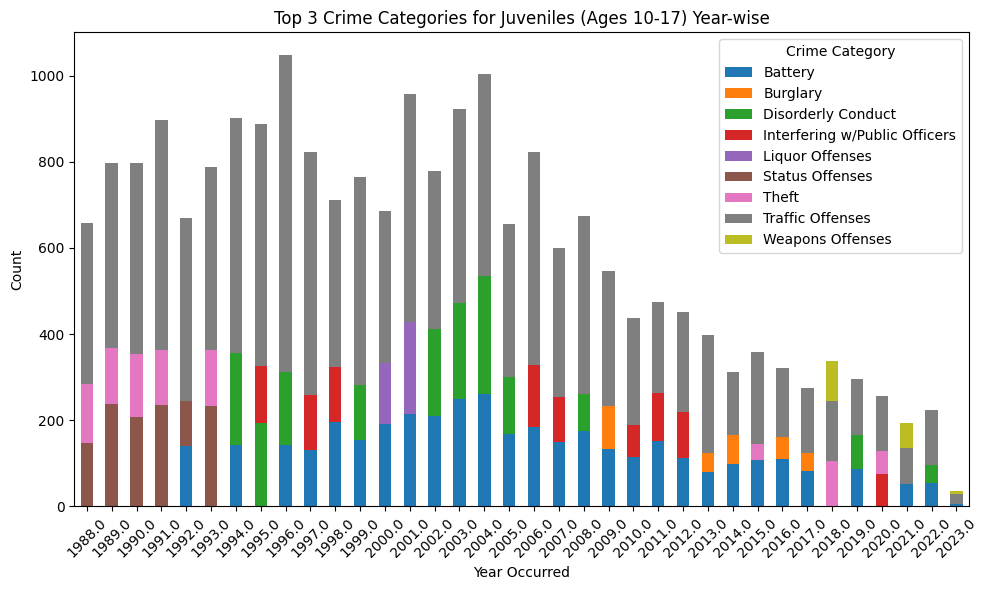

In [18]:
#Visualization depicting the Top 3 Crime categories committed by juveniles

top_crime_categories = juveniles_df.groupby(['YEAR.OCCURRED', 'CRIME.CATEGORY.DESCRIPTION'])['CRIME.CATEGORY.DESCRIPTION'].count().reset_index(name='COUNT')#groupby the crimecategory
top_crime_categories = top_crime_categories.sort_values(by=['YEAR.OCCURRED', 'COUNT'], ascending=[True, False])
top_crime_categories = top_crime_categories.groupby('YEAR.OCCURRED').head(3)
pivot_df = top_crime_categories.pivot(index='YEAR.OCCURRED', columns='CRIME.CATEGORY.DESCRIPTION', values='COUNT').fillna(0)
pivot_df.plot(kind='bar', stacked=True, figsize=(10, 6))# Plotting a stacked bar chart
plt.title('Top 3 Crime Categories for Juveniles (Ages 10-17) Year-wise')
plt.xlabel('Year Occurred')
plt.ylabel('Count')
plt.legend(title='Crime Category', bbox_to_anchor=(1, 1))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


<ipython-input-19-9a522c09d02f>:7: DtypeWarning: Columns (26,27,28) have mixed types. Specify dtype option on import or set low_memory=False.
  arrest_data = pd.read_csv('data.csv')


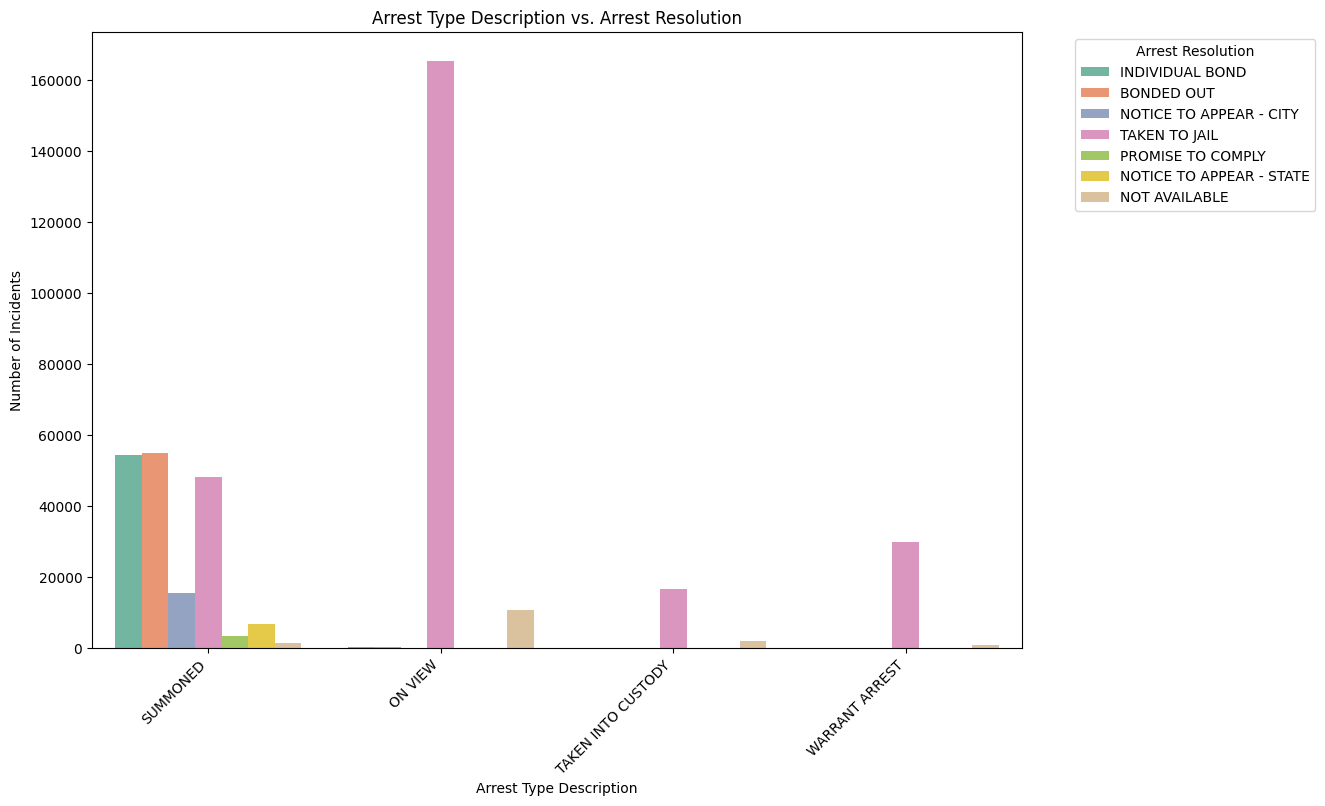

In [19]:
# Arrest desc vs Arrest Resolution
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


arrest_data = pd.read_csv('data.csv')

plt.figure(figsize=(12, 8))
sns.countplot(x='ARREST.TYPE.DESCRIPTION', hue='ARREST.RESOLUTION', data=arrest_data, palette='Set2')
plt.title('Arrest Type Description vs. Arrest Resolution')
plt.xlabel('Arrest Type Description')
plt.ylabel('Number of Incidents')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Arrest Resolution', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

<Figure size 1400x800 with 0 Axes>

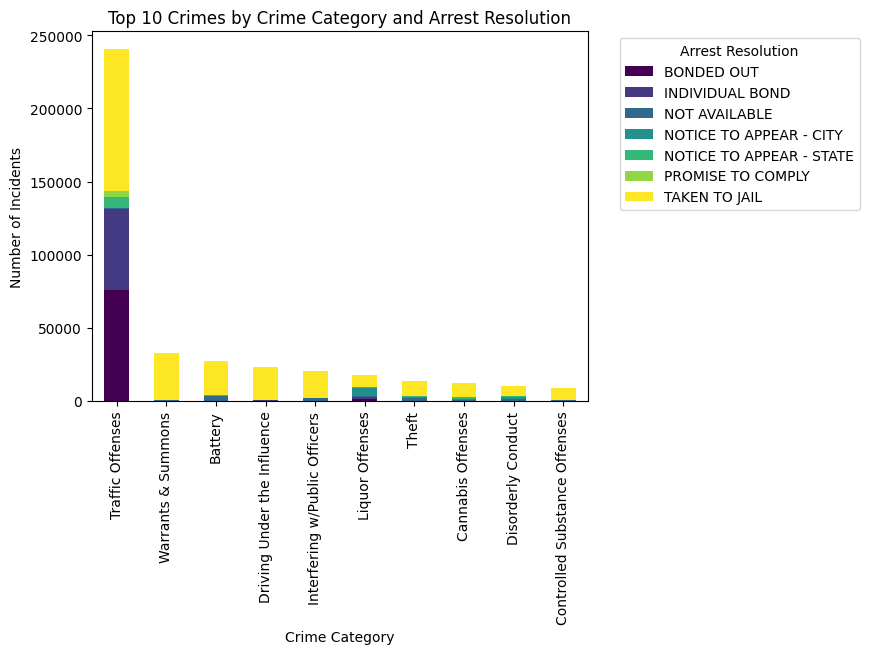

In [20]:
#Crime category vs Arrest Resolution
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


# Group by Crime Category and Arrest Resolution, count occurrences
crime_resolution_counts = data.groupby(['CRIME.CATEGORY.DESCRIPTION', 'ARREST.RESOLUTION']).size().unstack(fill_value=0)

# Select the top 10 crimes
top_10_crimes = crime_resolution_counts.sum(axis=1).sort_values(ascending=False).head(10).index
top_10_crime_resolution_counts = crime_resolution_counts.loc[top_10_crimes]

# Plot the top 10 crimes with arrest resolutions
plt.figure(figsize=(14, 8))
top_10_crime_resolution_counts.plot(kind='bar', stacked=True, colormap='viridis')
plt.title('Top 10 Crimes by Crime Category and Arrest Resolution')
plt.xlabel('Crime Category')
plt.ylabel('Number of Incidents')
plt.legend(title='Arrest Resolution', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

## **Prediction of the Arrest Resolution using Machine Learning methods**

Y variable: Arrest Resolution

Here, we intend on using the following ml methods:
* Logistic Regressor
* Naive Bayes Classifier
* KNN Classifier

Performance metrics:
Accuracy

In [21]:
print(data['ARREST.RESOLUTION'].value_counts())

TAKEN TO JAIL               289230
BONDED OUT                   77553
INDIVIDUAL BOND              57863
NOT AVAILABLE                18775
NOTICE TO APPEAR - CITY      15773
NOTICE TO APPEAR - STATE     13394
PROMISE TO COMPLY             4050
Name: ARREST.RESOLUTION, dtype: int64


### **Data Pre-processing before Machine Learning Model Creation**


In [22]:
#Dropping columns like incident and arrest number and weapon descriptions
ml_data=data.drop(['INCIDENT','ARREST.NUMBER', 'WEAPON.1.DESCRIPTION', 'WEAPON.2.DESCRIPTION', 'WEAPON.3.DESCRIPTION','ARRESTEE.HOME.CITY...MAPPED'],axis=1)

# Extracting month and year from arrest date
ml_data['DATE.OF.ARREST'] = pd.to_datetime(ml_data['DATE.OF.ARREST'])
ml_data['MONTH.ARREST'] = ml_data['DATE.OF.ARREST'].dt.month


# Extract year and month from date reported
ml_data['YEAR.REPORTED'] = ml_data['DATE.REPORTED'].dt.year
ml_data['MONTH.REPORTED'] = ml_data['DATE.REPORTED'].dt.month

#Dropping date columns since we have extracted information such as years and months
ml_data=ml_data.drop(['DATE.OF.ARREST','DATE.ARRIVED','DATE.REPORTED','DATE.OCCURRED'],axis=1)

# dropping the unknown rows for the age at arrest ml model
ml_data = ml_data[ml_data['AGE.AT.ARREST'] != 'Unknown']


In [23]:
# Showing the columns with na values
nan_values_per_column = ml_data.isna().sum()
print("Columns with NaN values:")
print(nan_values_per_column[nan_values_per_column > 0])

Columns with NaN values:
ARREST.TYPE.DESCRIPTION    65950
AGE.AT.ARREST               4172
ARRESTEE.RACE               1654
TIME.OCCURRED                 30
YEAR.OCCURRED                 30
MONTH.OCCURRED                30
TIME.REPORTED              10038
HOUR.OCCURRED                 30
HOUR.REPORTED              10038
Year                          30
Month                         30
Hour                          30
YEAR.REPORTED              10039
MONTH.REPORTED             10039
dtype: int64


In [24]:
# Replacing the na values in arrest description with Unknown
ml_data['ARREST.TYPE.DESCRIPTION'] = ml_data['ARREST.TYPE.DESCRIPTION'].replace({pd.NA: 'UNKNOWN'})
unknown_occurrences = ml_data['ARREST.TYPE.DESCRIPTION'].isna().sum()

# Replace NaN values with 'Unknown'
ml_data[['ARRESTEE.RACE']] = ml_data[['ARRESTEE.RACE']].fillna('Unknown')

# Specify the columns with NaN values
columns_with_nan = ['TIME.OCCURRED', 'YEAR.OCCURRED', 'MONTH.OCCURRED', 'HOUR.OCCURRED', 'YEAR.REPORTED', 'MONTH.REPORTED']

# Drop rows with NaN values in the specified columns
ml_data.dropna(subset=columns_with_nan, inplace=True)

#Dropping time rows since hour is represented
ml_data=ml_data.drop(['TIME.OCCURRED','TIME.REPORTED'],axis=1)

#Dropping na values in age at arrest
ml_data = ml_data.dropna(subset=['AGE.AT.ARREST'])

In [25]:
# Showing the columns with na values
nan_values_per_column = ml_data.isna().sum()
print("Columns with NaN values:")
print(nan_values_per_column[nan_values_per_column > 0])

Columns with NaN values:
Series([], dtype: int64)


In [26]:
ml_data['AGE.AT.ARREST'] = ml_data['AGE.AT.ARREST'].astype(int)

## **Feature Selection**

* Finding Top 5 Categorical features using Chi-Square
* Finding Top 5 Numerical features using ANOVA


In [27]:
#Finding the columns which are categorical
categorical= ml_data.select_dtypes(include=['object']).columns
print("The categorical columns in the dataset:", categorical)

The categorical columns in the dataset: Index(['ARREST.TYPE.DESCRIPTION', 'CRIME.CODE.DESCRIPTION',
       'CRIME.CATEGORY.DESCRIPTION', 'DISPOSITION.DESCRIPTION', 'ARRESTEE.SEX',
       'ARRESTEE.RACE', 'ARREST.RESOLUTION', 'HOUR.ARRIVED', 'STREET',
       'PLACE.CODE.DESCRIPTION', 'BIAS.DESCRIPTION', 'STATUS.DESCRIPTION',
       'Month'],
      dtype='object')


In [28]:
import pandas as pd
from sklearn.feature_selection import f_classif

#Finding the numerical columns
numerical_columns = ml_data.select_dtypes(include=['int64', 'float64']).columns
print(numerical_columns)

# Identify the target variable
target_variable = 'ARREST.RESOLUTION'

X = ml_data[numerical_columns]
y = ml_data[target_variable]

# Calculate ANOVA F-statistic and p-values
f_values, p_values = f_classif(X, y)
resultsanova = pd.DataFrame({'Feature': numerical_columns, 'F-Value': f_values, 'P-Value': p_values})

# Sort the ANOVA results by p-values
top_features_by_pvalue = resultsanova.sort_values(by='P-Value').head(5)

# Display the top features by p-value
print("\nTop 5 Features by P-Value:")
print(top_features_by_pvalue['Feature'])




Index(['YEAR.OF.ARREST', 'MONTH.OF.ARREST', 'AGE.AT.ARREST', 'YEAR.OCCURRED',
       'MONTH.OCCURRED', 'HOUR.OCCURRED', 'HOUR.REPORTED', 'Year', 'Hour',
       'MONTH.ARREST', 'YEAR.REPORTED', 'MONTH.REPORTED'],
      dtype='object')

Top 5 Features by P-Value:
0    YEAR.OF.ARREST
2     AGE.AT.ARREST
3     YEAR.OCCURRED
5     HOUR.OCCURRED
6     HOUR.REPORTED
Name: Feature, dtype: object


In [29]:
#label encoding the categorical values

from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()# Calling label encoder
columns_to_encode = [
      'ARREST.TYPE.DESCRIPTION', 'CRIME.CODE.DESCRIPTION',
       'CRIME.CATEGORY.DESCRIPTION', 'DISPOSITION.DESCRIPTION', 'ARRESTEE.SEX', 'ARRESTEE.RACE', 'ARREST.RESOLUTION',
       'STREET', 'PLACE.CODE.DESCRIPTION', 'BIAS.DESCRIPTION',
       'STATUS.DESCRIPTION']

for column in columns_to_encode:
    ml_data[column] = label_encoder.fit_transform(ml_data[column])

#### **Creating Machine learning Models for Arrest Resolution**

In [30]:
# Reference: https://towardsdatascience.com/using-the-chi-squared-test-for-feature-selection-with-implementation-b15a4dad93f1
from sklearn import datasets
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectKBest


#label encoding the categorical values

from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()# Calling label encoder
columns_to_encode = [
      'ARREST.TYPE.DESCRIPTION', 'CRIME.CODE.DESCRIPTION',
       'CRIME.CATEGORY.DESCRIPTION', 'DISPOSITION.DESCRIPTION', 'ARRESTEE.SEX', 'ARRESTEE.RACE', 'ARREST.RESOLUTION',
       'STREET', 'PLACE.CODE.DESCRIPTION', 'BIAS.DESCRIPTION',
       'STATUS.DESCRIPTION']

for column in columns_to_encode:
    ml_data[column] = label_encoder.fit_transform(ml_data[column])

# Assuming ml_data is your DataFrame containing the relevant data
X = ml_data[['ARREST.TYPE.DESCRIPTION', 'CRIME.CODE.DESCRIPTION',
       'CRIME.CATEGORY.DESCRIPTION', 'DISPOSITION.DESCRIPTION', 'ARRESTEE.SEX', 'ARRESTEE.RACE',
       'STREET', 'PLACE.CODE.DESCRIPTION', 'BIAS.DESCRIPTION',
       'STATUS.DESCRIPTION']]  # Features
y = ml_data['ARREST.RESOLUTION']  # Target variable

# Using SelectKBest with chi2 as the scoring function
test = SelectKBest(score_func=chi2, k=5)
fit = test.fit(X, y)


# Displaying chi-squared scores for each feature
chi2_scores = pd.DataFrame({'Feature': X.columns, 'Chi2': fit.scores_, 'P-value': fit.pvalues_})
print(chi2_scores)

# Sort the chi2_scores DataFrame by 'Chi2' column in descending order
sorted_chi2_scores = chi2_scores.sort_values(by='Chi2', ascending=False)


# Select the top 5 features
top_5_features = sorted_chi2_scores.head(5)

# Print the top 5 feature names
print("Top 5 Features:")
print(top_5_features['Feature'].tolist())


                      Feature          Chi2        P-value
0     ARREST.TYPE.DESCRIPTION  2.044730e+04   0.000000e+00
1      CRIME.CODE.DESCRIPTION  7.681799e+05   0.000000e+00
2  CRIME.CATEGORY.DESCRIPTION  7.470890e+05   0.000000e+00
3     DISPOSITION.DESCRIPTION  9.921593e+05   0.000000e+00
4                ARRESTEE.SEX  2.079345e+04   0.000000e+00
5               ARRESTEE.RACE  1.645478e+04   0.000000e+00
6                      STREET  7.589377e+02  1.143889e-160
7      PLACE.CODE.DESCRIPTION  1.010090e+06   0.000000e+00
8            BIAS.DESCRIPTION  6.752252e+02  1.364882e-142
9          STATUS.DESCRIPTION  9.069737e+03   0.000000e+00
Top 5 Features:
['PLACE.CODE.DESCRIPTION', 'DISPOSITION.DESCRIPTION', 'CRIME.CODE.DESCRIPTION', 'CRIME.CATEGORY.DESCRIPTION', 'ARRESTEE.SEX']


In [32]:
import pandas as pd
from sklearn.feature_selection import f_classif


# Identify the target variable
target_variable = 'ARREST.RESOLUTION'

# Assuming ml_data is your DataFrame containing the relevant data
X = ml_data[['YEAR.OF.ARREST', 'MONTH.OF.ARREST', 'AGE.AT.ARREST', 'YEAR.OCCURRED',
       'MONTH.OCCURRED', 'HOUR.OCCURRED', 'HOUR.REPORTED','YEAR.REPORTED', 'MONTH.REPORTED']]  # Features
y = ml_data['ARREST.RESOLUTION']  # Target variable

# Using SelectKBest with chi2 as the scoring function
test = SelectKBest(score_func=f_classif, k=5)
fit = test.fit(X, y)


# Displaying chi-squared scores for each feature
chi2_scores = pd.DataFrame({'Feature': X.columns, 'f': fit.scores_, 'P-value': fit.pvalues_})

# Sort the chi2_scores DataFrame by 'Chi2' column in descending order
sorted_chi2_scores = chi2_scores.sort_values(by='f', ascending=False)
print(chi2_scores)
# Select the top 5 features
top_5_features = sorted_chi2_scores.head(5)

# Print the top 5 feature names
print("Top 5 Features:")
print(top_5_features['Feature'].tolist())






           Feature            f       P-value
0   YEAR.OF.ARREST  8468.115041  0.000000e+00
1  MONTH.OF.ARREST    19.638108  4.688455e-23
2    AGE.AT.ARREST  4753.139638  0.000000e+00
3    YEAR.OCCURRED  8458.726074  0.000000e+00
4   MONTH.OCCURRED    20.505220  3.788573e-24
5    HOUR.OCCURRED   580.196043  0.000000e+00
6    HOUR.REPORTED   572.212345  0.000000e+00
7    YEAR.REPORTED  8461.562689  0.000000e+00
8   MONTH.REPORTED    20.590317  2.959176e-24
Top 5 Features:
['YEAR.OF.ARREST', 'YEAR.REPORTED', 'YEAR.OCCURRED', 'AGE.AT.ARREST', 'HOUR.OCCURRED']


In [33]:
#Importing the necessary scikit-learn libraries for the model creation

from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


X = ml_data[['PLACE.CODE.DESCRIPTION', 'DISPOSITION.DESCRIPTION', 'CRIME.CODE.DESCRIPTION', 'CRIME.CATEGORY.DESCRIPTION', 'ARRESTEE.SEX','YEAR.OF.ARREST', 'YEAR.REPORTED', 'YEAR.OCCURRED', 'AGE.AT.ARREST', 'HOUR.OCCURRED']]
y = ml_data['ARREST.RESOLUTION'] #Defining the dependant variable


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) # Split the data into training and testing sets

In [34]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_predict
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
import pandas as pd
from sklearn.model_selection import train_test_split

# Assuming you have X_train, y_train, X_test, y_test defined

# Define the cross-validation splitter
cv_splitter = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

def evaluate_model(model, X_train, y_train, X_test, y_test, model_name):
    # Cross-validation
    y_pred_train = cross_val_predict(model, X_train, y_train, cv=cv_splitter)

    # Predictions on test set
    y_pred_test = model.fit(X_train, y_train).predict(X_test)

    # Print metrics for training set
    print(f"{model_name} Metrics on Training Set:")
    print(classification_report(y_train, y_pred_train))

    # Print metrics for test set
    print(f"{model_name} Metrics on Test Set:")
    print(classification_report(y_test, y_pred_test))
    print()

# Logistic Regression
lr = LogisticRegression(max_iter=500)
evaluate_model(lr, X_train, y_train, X_test, y_test, "Logistic Regression")

# Naive Bayes Classifier
param_grid_nb = {
    'alpha': [0.1, 0.5, 1.0, 1.5],
    'fit_prior': [True, False]
}
nb = MultinomialNB()
grid_search_nb = GridSearchCV(nb, param_grid_nb, cv=cv_splitter, scoring='accuracy')
grid_search_nb.fit(X_train, y_train)
best_nb = grid_search_nb.best_estimator_
evaluate_model(best_nb, X_train, y_train, X_test, y_test, "Naive Bayes")

# KNN Classifier
knn = KNeighborsClassifier(n_neighbors=5)
evaluate_model(knn, X_train, y_train, X_test, y_test, "KNN")


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Logistic Regression Metrics on Training Set:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

              precision    recall  f1-score   support

           0       0.65      0.52      0.58     58166
           1       0.47      0.63      0.54     45710
           2       0.62      0.23      0.33     14172
           3       0.54      0.21      0.31     12615
           4       0.00      0.00      0.00      9871
           5       0.00      0.00      0.00      3142
           6       0.72      0.81      0.76    226241

    accuracy                           0.67    369917
   macro avg       0.43      0.34      0.36    369917
weighted avg       0.65      0.67      0.65    369917

Logistic Regression Metrics on Test Set:
              precision    recall  f1-score   support

           0       0.71      0.21      0.33     14596
           1       0.45      0.59      0.51     11368
           2       0.66      0.07      0.12      3466
           3       0.69      0.19      0.30      3089
           4       0.00      0.00      0.00      2444
           5       0.00      0.00    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Naive Bayes Metrics on Training Set:
              precision    recall  f1-score   support

           0       0.40      0.67      0.50     58166
           1       0.55      0.44      0.49     45710
           2       0.08      0.56      0.15     14172
           3       0.40      0.36      0.38     12615
           4       0.06      0.20      0.09      9871
           5       0.02      0.36      0.04      3142
           6       0.64      0.14      0.23    226241

    accuracy                           0.29    369917
   macro avg       0.31      0.39      0.27    369917
weighted avg       0.54      0.29      0.30    369917

Naive Bayes Metrics on Test Set:
              precision    recall  f1-score   support

           0       0.39      0.67      0.50     14596
           1       0.54      0.43      0.48     11368
           2       0.08      0.56      0.15      3466
           3       0.41      0.38      0.39      3089
           4       0.06      0.21      0.10      2444
        

In [35]:

# KNN Classifier with Manhattan distance
knn_manhattan_model = KNeighborsClassifier(n_neighbors=5, metric='manhattan')
evaluate_model(knn_manhattan_model, X_train, y_train, X_test, y_test, "KNN with Manhattan")

KNN with Manhattan Metrics on Training Set:
              precision    recall  f1-score   support

           0       0.87      0.84      0.85     58166
           1       0.90      0.95      0.92     45710
           2       0.87      0.80      0.84     14172
           3       0.94      0.91      0.93     12615
           4       0.78      0.62      0.69      9871
           5       0.38      0.12      0.18      3142
           6       0.94      0.97      0.96    226241

    accuracy                           0.92    369917
   macro avg       0.81      0.74      0.77    369917
weighted avg       0.92      0.92      0.92    369917

KNN with Manhattan Metrics on Test Set:
              precision    recall  f1-score   support

           0       0.90      0.84      0.87     14596
           1       0.91      0.95      0.93     11368
           2       0.89      0.84      0.86      3466
           3       0.95      0.92      0.94      3089
           4       0.80      0.67      0.73     